Custom-CNN

In [1]:
!pip install torchinfo

### Import Libraries

In [2]:
import os
import time
import platform
import psutil
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from PIL import Image
import PIL

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from torchvision import transforms

# INSERT/VERIFY near top of notebook
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, f1_score
import itertools

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### Configuration

In [4]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [5]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [6]:
data_dir = "/kaggle/input/dataset-for-cotton-leaf-disease-detection/SAR-CLD-2024 A Comprehensive Dataset for Cotton Leaf Disease Detection/Augmented Dataset/Augmented Dataset"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
#df['label'] = df['label'].str.strip()
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
num_classes = len(label_map)

Class: Leaf Hopper Jassids, Count: 1000
Class: Leaf Redding, Count: 1000
Class: Healthy Leaf, Count: 1000
Class: Herbicide Growth Damage, Count: 1000
Class: Bacterial Blight, Count: 1000
Class: Leaf Variegation, Count: 1000
Class: Curl Virus, Count: 1000


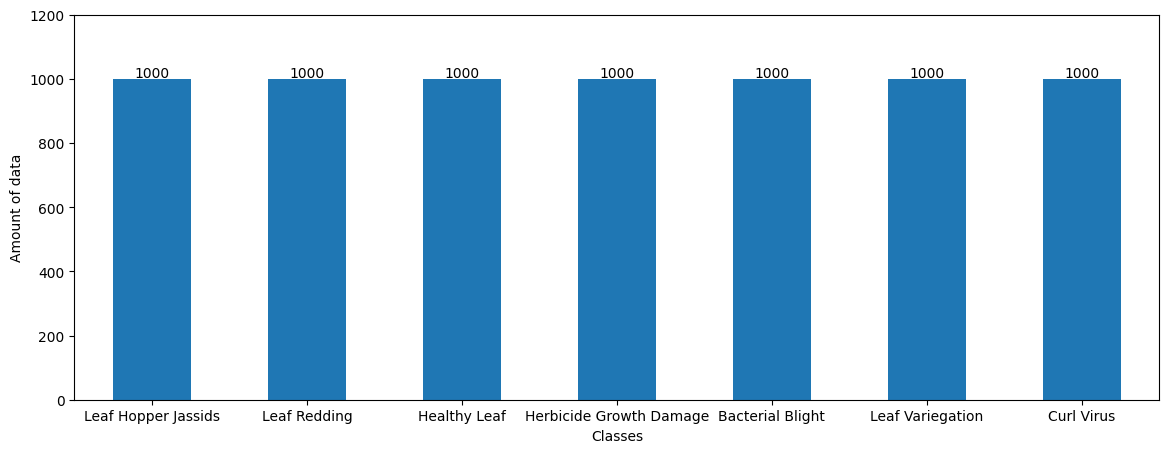

In [8]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 5))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

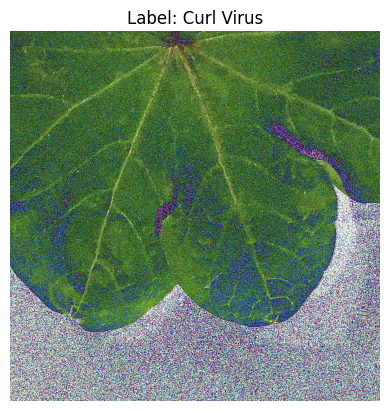

In [9]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [10]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [11]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  4900
Validation Data:  1050
Test Data:  1050
-------------------------------------------
Total amounts of data in the dataset:  7000


In [12]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                      Count
-----------------------  -------
Healthy Leaf                 700
Curl Virus                   700
Bacterial Blight             700
Leaf Redding                 700
Leaf Hopper Jassids          700
Leaf Variegation             700
Herbicide Growth Damage      700

Validation Dataset
Class                      Count
-----------------------  -------
Leaf Variegation             150
Leaf Hopper Jassids          150
Healthy Leaf                 150
Herbicide Growth Damage      150
Curl Virus                   150
Bacterial Blight             150
Leaf Redding                 150

Test Dataset
Class                      Count
-----------------------  -------
Bacterial Blight             150
Leaf Redding                 150
Healthy Leaf                 150
Herbicide Growth Damage      150
Leaf Hopper Jassids          150
Leaf Variegation             150
Curl Virus                   150


### Device Variable

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [14]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [15]:

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_lb=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.is_lb = is_lb
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"[Warning] Could not load image {img_path}. Error: {e}")
            image = Image.new("RGB", (128, 128), color=(0, 0, 0))
        
        if self.transform:
            image = self.transform(image)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return image, label
        else:
            return image, image


In [16]:
train_batch = 32
val_batch = 8

def data_transfrom():
    # Strong augmentation for training set
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop & resize
        transforms.RandomHorizontalFlip(p=0.5),               # Flip 50% chance
        transforms.RandomRotation(degrees=15),                # Rotate ±15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color change
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),     # Standard ImageNet normalization
        transforms.RandomErasing(p=0.2)                       # Erase random patch
    ])

    # Validation & test transforms (no augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = ImageDataset(train_dataframe, train_transforms, is_lb=True)
    valid_dataset = ImageDataset(valid_dataframe, val_transforms, is_lb=True)
    test_dataset = ImageDataset(test_df, val_transforms, is_lb=True)

    # Create dataloaders
    dataloader_train_dataset = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

# Load datasets with augmentation
dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()


### Custom-CNN

In [17]:
# Custom CNN with Batch Normalization
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),     # 128x128x3 → 128x128x16
            nn.BatchNorm2d(16),                              # BN after conv
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # → 64x64x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),     # → 64x64x32
            nn.BatchNorm2d(32),                              # BN after conv
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # → 32x32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),     # → 32x32x64
            nn.BatchNorm2d(64),                              # BN after conv
            nn.ReLU(),
            nn.AvgPool2d(2, 2),                              # → 16x16x64
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                    # → 16*16*64 = 16384
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Model setup block

In [18]:
# Setup for Custom CNN Model
num_classes = len(label_map)  
learning_rate = 0.001

# Initialize the custom model
model = CustomCNN(num_classes=num_classes).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Model summary using 128x128 input size
summary(model, input_size=(train_batch, 3, 128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
CustomCNN                                [32, 7]                   --
├─Sequential: 1-1                        [32, 64, 16, 16]          --
│    └─Conv2d: 2-1                       [32, 16, 128, 128]        448
│    └─BatchNorm2d: 2-2                  [32, 16, 128, 128]        32
│    └─ReLU: 2-3                         [32, 16, 128, 128]        --
│    └─MaxPool2d: 2-4                    [32, 16, 64, 64]          --
│    └─Conv2d: 2-5                       [32, 32, 64, 64]          4,640
│    └─BatchNorm2d: 2-6                  [32, 32, 64, 64]          64
│    └─ReLU: 2-7                         [32, 32, 64, 64]          --
│    └─MaxPool2d: 2-8                    [32, 32, 32, 32]          --
│    └─Conv2d: 2-9                       [32, 64, 32, 32]          18,496
│    └─BatchNorm2d: 2-10                 [32, 64, 32, 32]          128
│    └─ReLU: 2-11                        [32, 64, 32, 32]          --
│    └

In [19]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total
    return loss, accuracy


In [20]:
def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset,
                num_epochs=10, early_stop_patience=5, save_path_checkpoints=None):
    
    best_loss = float('inf')
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    learning_rates = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in dataloader_train_dataset:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Evaluate on validation set
        model.eval()
        val_loss, val_acc = evaluate_model(model, criterion, dataloader_valid_dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch {epoch+1}/{num_epochs} => "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            if save_path_checkpoints:
                torch.save({
                    'epoch': epoch,
                    'model_weight': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                }, os.path.join(save_path_checkpoints, "model.pt"))
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, learning_rates


### Training

In [21]:
MODEL_TYPE = "custom"

print(f"\nStarting training for {MODEL_TYPE.upper()} CNN...")
start_time = time.time()

# Train the model
train_loss_history, train_acc_history, val_loss_history, val_acc_history, learning_rates = train_model(
    model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, 
    num_epochs=300, early_stop_patience=200, save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

# Save training history
data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history,
    'Learning Rate': learning_rates
}

history = pd.DataFrame(data)
history.to_excel(f'/kaggle/working/custom_{MODEL_TYPE}_training_data.xlsx', index=False)


Starting training for CUSTOM CNN...
Epoch 1/300 => Train Loss: 1.8394, Train Acc: 0.3769, Val Loss: 1.4911, Val Acc: 0.4610
Epoch 2/300 => Train Loss: 1.5038, Train Acc: 0.4739, Val Loss: 1.2619, Val Acc: 0.6181
Epoch 3/300 => Train Loss: 1.4320, Train Acc: 0.5233, Val Loss: 1.2230, Val Acc: 0.6305
Epoch 4/300 => Train Loss: 1.3854, Train Acc: 0.5384, Val Loss: 1.2450, Val Acc: 0.6238
Epoch 5/300 => Train Loss: 1.3390, Train Acc: 0.5659, Val Loss: 1.1060, Val Acc: 0.7114
Epoch 6/300 => Train Loss: 1.3132, Train Acc: 0.5769, Val Loss: 1.0837, Val Acc: 0.7171
Epoch 7/300 => Train Loss: 1.2996, Train Acc: 0.6014, Val Loss: 1.0726, Val Acc: 0.7314
Epoch 8/300 => Train Loss: 1.2598, Train Acc: 0.6163, Val Loss: 1.1056, Val Acc: 0.7067
Epoch 9/300 => Train Loss: 1.2571, Train Acc: 0.6171, Val Loss: 1.0403, Val Acc: 0.7695
Epoch 10/300 => Train Loss: 1.2254, Train Acc: 0.6384, Val Loss: 0.9921, Val Acc: 0.7762
Epoch 11/300 => Train Loss: 1.2066, Train Acc: 0.6478, Val Loss: 0.9552, Val Acc: 

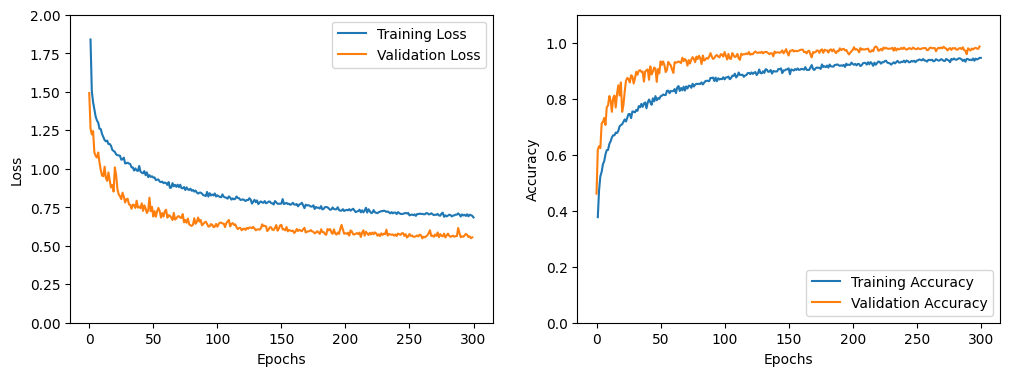

In [22]:
history = pd.read_excel('/kaggle/working/custom_custom_training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [23]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [24]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 260) - Validation Loss: 0.548, Validation Accuracy: 0.981


In [25]:
# --- Feature Extraction Helper ---
def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model.features(images)              # only CNN part
            outputs = outputs.view(outputs.size(0), -1)   # flatten
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    return np.concatenate(features), np.concatenate(labels)


In [26]:
# Extract features using trained CNN
X_train, y_train = extract_features(model, dataloader_train_dataset, device)
X_test, y_test   = extract_features(model, dataloader_test_dataset, device)

print("Train features:", X_train.shape, " Test features:", X_test.shape)


Train features: (4900, 16384)  Test features: (1050, 16384)


In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train SVM
svm_clf = SVC(kernel='rbf', C=10, gamma='scale')
svm_clf.fit(X_train, y_train)

# Evaluate on test set
y_pred = svm_clf.predict(X_test)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


import time
start = time.time()
svm_clf.fit(X_train, y_train)
end = time.time()
print(f"SVM Training Time: {end-start:.2f} sec")


SVM Test Accuracy: 0.9552380952380952

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       150
           1       0.90      0.93      0.92       150
           2       0.97      0.95      0.96       150
           3       0.99      0.96      0.98       150
           4       0.92      0.96      0.94       150
           5       0.96      0.91      0.93       150
           6       0.99      0.99      0.99       150

    accuracy                           0.96      1050
   macro avg       0.96      0.96      0.96      1050
weighted avg       0.96      0.96      0.96      1050


Confusion Matrix:
 [[148   1   0   0   1   0   0]
 [  0 140   5   1   2   2   0]
 [  0   6 143   0   1   0   0]
 [  0   6   0 144   0   0   0]
 [  1   2   0   0 144   3   0]
 [  6   0   0   0   7 136   1]
 [  0   0   0   0   1   1 148]]
SVM Training Time: 153.67 sec
